# Pipeline for Processing GeneLab Amplicon Sequencing Data

> **The 3 Amplicon Seq Jupyter Notebook (JNs) are designed for processing samples derived from the feces of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 6 mission. More information about the samples analyzed here can be found in the [Open Science Data Repository (OSDR)](https://osdr.nasa.gov/bio/repo/) under [OSD-249](https://osdr.nasa.gov/bio/repo/data/studies/OSD-249). We will be processing these samples using the [GeneLab Amplicon Sequencing Data Processing Pipeline](https://github.com/nasa/GeneLab_Data_Processing/blob/master/Amplicon/Illumina/Pipeline_GL-DPPD-7104_Versions/GL-DPPD-7104-A.md) for Illumina sequence data.**  

<br>

---

## Amplicon Pipeline Overview
> This JN will cover the pipeline steps outlined in red. 
> Note that after assessing raw data quality, we will move to the [Amplicon Processing JN](02-amplicon-processing.ipynb) for the Primer Removal and Quality Filtering/Trimming steps, then return to this JN to assess the filtered and trimmed data quality. 

<br>
<center>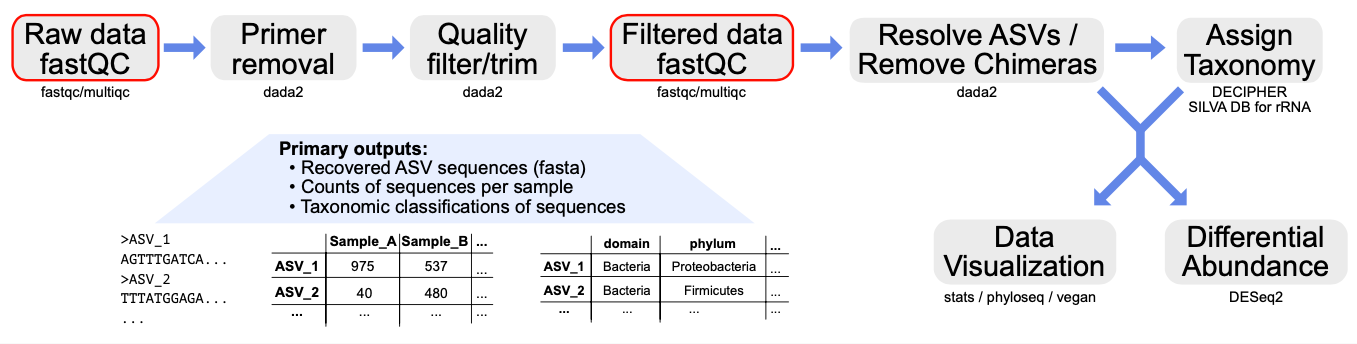</center>


---


<hr style="height:0px; visibility:hidden;" />

<h1><center>1. Setup and QC</center></h1>

<div class="alert alert-block alert-success">
Here we are going to setup a directory structure to store the output data we'll generate, and we are going to use a popular tool for assessing the quality of our reads. Both of these are most easily done at a Unix-like command line, so this notebook uses a "Bash" kernel, a common language used in a Unix-like environment. 
</div>

---

This is notebook 1 of 3 of <a href="00-amplicon-overview.ipynb">GL4U's Amplicon Seq Bootcamp</a>. 

---

[**Previous:** Amplicon overview](00-amplicon-overview.ipynb)
<br>

<div style="text-align: right"><a href="02-amplicon-processing.ipynb"><b>Next:</b> 2. Amplicon processing</a></div>

---
---

# Table of Contents

* [1. Setting up](#setup)
* [2. Quality assessment of raw reads](#rawqa) 
* [3. Quality assessment of trimmed/filtered reads](#filteredqa)

<br>

---
---

<a class="anchor" id="setup"></a>

## 1. Setting up
First we are going to create a new directory within our "home" location for us to work in using the `mkdir` command, and then we'll use the `cd` command to change into the directory we made:

In [ ]:
mkdir -p ~/GL4U-amplicon-tutorial
cd ~/GL4U-amplicon-tutorial

<div class="alert alert-block alert-info">
<b>Note</b><br>
The <code>-p</code> option included above with the <code>mkdir</code> command is added so that if we need to re-run that code block for any reason, it won't throw an error when we try to create a directory that exists already (which is the default behavior of <code>mkdir</code>).
</div>

Now let's check where we are and if there are any files/directories present:

In [ ]:
pwd
ls

Next we are going to download the raw data files that we will start with and then unpack them with these commands:

In [ ]:
curl -L -o raw-reads.tar.gz https://figshare.com/ndownloader/files/39537235
tar -x -f raw-reads.tar.gz
rm raw-reads.tar.gz

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `curl`   - the primary command we're using, which can download files from the internet
    - `-L`   - this tells `curl` to follow any redirecting links if they exist
    - `-o`   - the output name we want to give to the file we're downloading
    - last to `curl` is a positional arugment that is the address of the file we want to download

- `tar` - the primary command we're using, a "tar" is a type of archive that can hold one or more files and directories, and this command allows us to create or open them
    - `-x` - this tells `tar` to extract the files in the tar archive
    - `-f` - this is where we specify the input tar file we want the command to operate on
    
Lastly, we are removing the "raw-reads.tar.gz" file after we extracted the files from it. 
</div>

<div class="alert alert-block alert-info">
<b>Note</b><br>

For the purposes of this bootcamp we are only downloading a subset of the [OSD-249](https://osdr.nasa.gov/bio/repo/data/studies/OSD-249) raw reads from ISS terminal (ISS-T) fecal samples prepared using the [Fluidigm Access Array](https://www.standardbio.com/support/instrument-support/access-array-support) library preparation method.

</div>

Now we can see we have them:

In [ ]:
ls

In [ ]:
ls raw-reads

And we also grabbed a file with some sample information. Let's move that file to our current directory and take a look at it with the `cat` command:

In [ ]:
mv raw-reads/sample-info.tsv .

In [ ]:
cat sample-info.tsv

The columns are not perfectly aligned across each row when using `cat`. This just has to do with how the print-out is positioning things and does not mean anything is wrong with our tab-delimited file. 

We can use a command called `column` to help with formatting the print-out (where `-t` tells it to try to make a table):

In [ ]:
column -t sample-info.tsv


<div class="alert alert-block alert-info">
<b>Note</b><br>

The colors listed are [R color names](https://r-graph-gallery.com/42-colors-names.html).

</div>

**Take a look at the sample-info.tsv file above and answer the following questions:**

1. How many samples are there? 
2. How many samples are derived from spaceflight? How do you know?


<div class="alert alert-block alert-success">

<details>
<summary><b>Solutions</b></summary>

<br>

<b>1.</b> 10 samples<br>
<b>2.</b> 5 samples, going by what's in the "treatment" column
    
</details>
</div>

Lastly for setup, we're going to create all the directories to store the output data we'll generate while processing:

In [ ]:
mkdir -p trimmed-and-filtered-reads fastqc-outputs/raw fastqc-outputs/trimmed-and-filtered final-outputs

In [ ]:
ls

---

<a class="anchor" id="rawqa"></a>

## 2. Quality assessment of raw reads

We are going to use the popular tool [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to assess some basic quality metrics about our raw reads. 

This program will evaluate the information provided for each read in the fastq files and generate a summary report about the quality of the sequence data. Assessing the raw sequence quality is important for determining if and how the reads need to be trimmed.

Here is how we can run it on our raw reads:

In [ ]:
fastqc -t 6 -q -o fastqc-outputs/raw raw-reads/*.gz 

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `fastqc`   - the primary command we're using
    - `-t`   - where we can specify how many we want to process at a time in parallel
    - `-q`   - telling the program not to print out everything it's doing (just because it's a little messy when running in parallel)
    - `-o`   - the directory where we want to put the output files
    - `raw-reads/*.gz` - this is providing all read files as a *positional* arugment (like we covered in the Unix Intro JN), the `*` is a wildcard that here means get anything in that directory that ends with `.gz`

</div>

In [ ]:
ls fastqc-outputs/raw

This program produces a zipped directory holding data and a summary html file for each fastq file we gave it. We can look at one of these by navigating to it on the left and double-clicking on the html file, or just by [**clicking here for sample F10_R1**](../GL4U-amplicon-tutorial/fastqc-outputs/raw/F10_R1_raw_fastqc.html). 

<div class="alert alert-block alert-warning">
Depending on where these Jupyter notebooks are stored, the above link may not work, and it might not be possible to navigate to the location inside Jupyter Lab. If that's the case, you can use a browser or finder window on your computer and navigate to "~/GL4U-amplicon-tutorial/fastqc-outputs/raw/" and then you can open the html files from there.
</div>


<div class="alert alert-block alert-info">
<b>Note</b><br>

As we covered earlier, there are many modules included in the `fastqc` program, with the documentation for each linked on [this page](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/). While these are summarized in a pass (green check), warning (yellow exclamation point), and fail (red X) fashion, it is important to remember that those indicators are based on expecting the data are completely random and diverse, which is often not the case depending on the type of sequencing that was done.

</div>

Rather than looking through all of the fastqc reports individually, we can take advantage of [MultiQC](https://multiqc.info/) to combine them for us:

In [ ]:
multiqc -o fastqc-outputs -n raw_multiqc fastqc-outputs/raw/

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `multiqc`   - the primary command we're using
    - `-o`   - the directory where we want to put the output files
    - `-n`   - specifies the prefix name for the output files
    - `fastqc-outputs/raw/` - the relative path to the directory holding the raw FastQC data from each sample, provided as a positional argument

</div>

And we can see the multiqc outputs were produced by looking in the location we specified as the ouput directory:

In [ ]:
ls fastqc-outputs

Multiqc produces a data directory and also a summary html file. We can open and look at the multiqc summary with the file browser on the left, or by [**clicking here**](../GL4U-amplicon-tutorial/fastqc-outputs/raw_multiqc.html). Be sure to click "Trust HTML" at the top-left after opening. 

<div class="alert alert-block alert-warning">
Depending on where these Jupyter notebooks are stored, the above link may not work, and it might not be possible to navigate to the location inside Jupyter Lab. If that's the case, you can use a browser or finder window on your computer and navigate to "~/GL4U-amplicon-tutorial/fastqc-outputs/" and then you can open the raw_multiqc.html file from there.
</div>

**Take a look at the multiQC report of the raw fastQC data and answer the following questions:**

1. Which sample was sequenced at the greatest read depth? The least read depth? (Hint: Click on the "Number of reads" button in the "Sequence Counts" section.)

2. What do you notice about the quality of the raw sequence data (from the "Sequence Quality Histograms" module)? Are there any differences between the forward and reverse reads?

4. Were adapters detected?

5. Should we be worried about any of the modules that "failed"?

6. Should we trim and/or filter the data? Why or why not?

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Sample G5 has the most reads at about 32,000. And Sample G9 has the fewest at about 25,000.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The quality scores stay above 35 for pretty much the entire reads. The little dip at the start is common (likely because of low sequence diversity at the start, lowering the confidence of the base calls there). 
    
Here there is no real difference between the forward and reverse reads, which is pretty atypical. Normally the reverse reads have slightly slower quality towards their ends than do the forward reads.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

No, these would be listed in the "Adapter Content" module.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

No, we don't need to worry about them. Failed ones here include "Per Base Sequence Content", "Per Sequence GC Content", "Sequence Duplication Levels", and "Overrepresented Sequences". For the type of sequencing done here, where we are making many copies of one portion of one gene, these are all expected to "fail", as our sequencing is intentionally not resulting in a random and diverse library of sequences. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q5 Solution</b></summary>

<br>

While these data look pretty great overall, it is still a good idea to trim/filter them. One arguable reason to do so is that these quality plots only show the averages, so there may be some reads with poor quality we might still want to filter out. And there can be other reasons to want to filter/trim still, but there wouldn't be many reasons to *not* do it.

</details>
</div>

---

**For now, we are going to move onto our [amplicon processing notebook](02-amplicon-processing.ipynb), but we will return here after we filter our reads in order to use FastQC/MultiQC again.**

---

<a class="anchor" id="filteredqa"></a>

## 3. Quality assessment of trimmed/filtered reads

After we've generated our trimmed and filtered reads in the amplicon processing notebook, we can move forward here to assess their quality using fastqc and multiqc.

First let's check that our filtered read files are present where we expect them to be:

In [ ]:
cd ~/GL4U-amplicon-tutorial
ls trimmed-and-filtered-reads

Now we'll run fastqc and multiqc the same way we did above, except we'll point to the files in the trimmed-and-filtered-reads directory:

In [ ]:
fastqc -t 6 -q -o fastqc-outputs/trimmed-and-filtered trimmed-and-filtered-reads/*.gz 

In [ ]:
multiqc -o fastqc-outputs -n filtered_multiqc fastqc-outputs/trimmed-and-filtered/

And we can see the new multiqc outputs have been created in the location we specified: 

In [ ]:
ls fastqc-outputs

Then like before, we can open and look at the multiqc summary with the file browser on the left, or by [**clicking here**](../GL4U-amplicon-tutorial/fastqc-outputs/filtered_multiqc.html). Be sure to click "Trust HTML" at the top-left after opening.

<div class="alert alert-block alert-warning">
Depending on where these Jupyter notebooks are stored, the above link may not work, and it might not be possible to navigate to the location inside Jupyter Lab. If that's the case, you can use a browser or finder window on your computer and navigate to "~/GL4U-amplicon-tutorial/fastqc-outputs/" and then you can open the filtered_multiqc.html file from there.
</div>

**Take a look at the multiQC report of the trimmed and filtered fastQC data above and answer the following questions:**

1. How many reads are there in the G5 sample after trimming? What about the G9 sample? Are they still the samples sequenced at the greatest and least read depth, respectively? (Hint: Click on the "Number of reads" button in the "Sequence Counts" section.)

2. What is the sequencing depth range among samples? Do you think this is an issue? 

3. What do you notice about the quality of the trimmed sequence data compared with the raw (looking at the "Sequence Quality Histograms" module)?

4. Looking at the "Sequence Length Distribution" section, what length are the trimmed and filtered reads? Does it look like we met our minimum target of 264 for a combined length of read-pairs that we identified in the processing notebook?

5. Do you think we're ready to move forward with these filtered data? Why or why not?


<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

G5 has just over 28,000 reads (down from about 32,000), and G9 has just over 22,000 (down from about 25,000). 

Yes, G5 and G9 are still the 2 samples with the greatest and fewest reads, respectively.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The range is about 22,000 reads to 28,000. Most would not consider this an issue, though whether we decide something is an issue or not is subjective, and it is often based on what these data typically look like. So it is hard to say when you're not yet used to looking at these types of summary metrics for a given data type.


</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

While the starting data quality was already pretty good, it is even more consistent now and there is no dip in quality in the front. 

</details>
</div>



<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

They are virtually all 132 bases. Yes, 132 + 132 gives us the minimum we wanted to see of 264. It is right on the line though, it will be important to check at the end if we appeared to lose a lot of reads at the merging step.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q5 Solution</b></summary>

<br>

Yes, they have high quality profiles, no adapter content detected, and the primers have been removed.

</details>
</div>


<br>

---

**Now let's head back to the [amplicon processing notebook](02-amplicon-processing.ipynb#errormod), where we are ready to proceed with generating an error model of our data.**


---
---

[**Previous:** Amplicon overview](00-amplicon-overview.ipynb)
<br>

<div style="text-align: right"><a href="02-amplicon-processing.ipynb"><b>Next:</b> 2. Amplicon processing</a></div>

